In [ ]:
#!pip install --upgrade scikit-learn
#!pip install scipy==1.4 --upgrade
!pip install dalex
!pip install --upgrade geopandas

**Random Forest Model with sklearn package**

In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
from numpy import std
import geopandas as gpd
import matplotlib.pyplot as plt

**Variable selection and statistical significance**

In [105]:
raw_data = pd.read_csv('Grid_250m_As_JG_predictor.csv') # Grid averaged As data and predictors at centroid location
raw_data

,OBJECTID,Point_Count,MEAN_As_field,As_class,STD_As_field,ts_soc,ts_silt,ts_sand,ts_ph,ts_clay,ts_cec,ts_bulkdensity,ss_soc,ss_silt,ss_sand,ss_ph,ss_clay,ss_cec,ss_bulkdensity,fluvisols,et0_yr,ai_et0,elevation,slope,precip,temp,distance_to_river,lulc,twi,ts_cf,ss_cf,latitude,longitude
0,14989,1,0.000000,0,0.000000,256,340,386,54,273,179,123,63,272,315,55,413,143,135,6,1500,11591,120,0.328490,1739,24.116667,640.149402,2,112,158,249,26.179411,93.999469
1,16644,1,27.000000,1,0.000000,256,324,357,57,319,194,122,76,292,335,58,373,158,135,6,1489,12322,123,0.328490,1835,24.050000,2136.156457,2,112,165,228,26.315191,94.069099
2,15970,1,35.000000,1,0.000000,269,328,357,56,315,185,122,68,281,328,57,391,150,135,6,1491,12116,132,0.328490,1807,23.975000,465.903551,2,111,173,247,26.272964,94.069210
3,15404,3,341.333333,1,274.818728,276,334,347,57,318,199,124,65,305,318,58,377,162,134,6,1495,11820,115,0.328490,1768,24.116667,527.069827,2,114,164,240,26.231744,94.010314
4,47049,1,500.000000,1,0.000000,265,321,402,57,277,165,126,56,268,321,59,411,138,136,7,1483,12764,114,0.328490,1893,24.058333,277.008355,2,116,168,208,26.382968,94.128657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,30668,2,0.000000,0,0.000000,242,334,402,54,264,175,122,88,300,349,55,351,149,133,8,1485,14052,91,8.805429,2088,24.100000,1319.758530,2,110,167,250,26.610469,93.734584
2388,55934,1,0.000000,0,0.000000,220,315,407,53,278,180,128,76,297,358,54,345,157,135,19,1471,14677,92,8.805429,2160,23.983333,1041.338172,10,117,112,149,26.656383,93.984746
2389,36247,1,0.000000,0,0.000000,241,338,397,55,265,163,124,62,325,339,56,336,146,137,13,1490,14469,89,9.125731,2156,24.133333,1438.933689,2,116,135,167,26.661029,93.789792
2390,28406,1,0.000000,0,0.000000,243,376,381,55,243,155,124,73,357,327,56,316,137,134,8,1486,14178,94,10.200527,2107,24.083333,1853.253930,2,112,171,198,26.617150,93.636350


In [106]:
cols = ["ss_bulkdensity", "ss_cf", "ss_ph", "ts_bulkdensity", "ts_cf", "ts_ph", "ts_soc", "ts_silt", "ts_sand", "ts_clay", "ts_cec",
                "ss_soc", "ss_silt", "ss_sand" , "ss_clay", "ss_cec", "fluvisols"]
raw_data[cols] = raw_data[cols].replace({0:np.nan}) # to remove/replace data with no values/zeros to NaN
#raw_data["ts_soc"].replace(to_replace=0, value=np.nan, inplace=True) # to remove/replace data with no values/zeros to NaN
raw_data

,OBJECTID,Point_Count,MEAN_As_field,As_class,STD_As_field,ts_soc,ts_silt,ts_sand,ts_ph,ts_clay,ts_cec,ts_bulkdensity,ss_soc,ss_silt,ss_sand,ss_ph,ss_clay,ss_cec,ss_bulkdensity,fluvisols,et0_yr,ai_et0,elevation,slope,precip,temp,distance_to_river,lulc,twi,ts_cf,ss_cf,latitude,longitude
0,14989,1,0.000000,0,0.000000,256,340,386,54,273,179,123,63,272,315,55,413,143,135,6,1500,11591,120,0.328490,1739,24.116667,640.149402,2,112,158,249,26.179411,93.999469
1,16644,1,27.000000,1,0.000000,256,324,357,57,319,194,122,76,292,335,58,373,158,135,6,1489,12322,123,0.328490,1835,24.050000,2136.156457,2,112,165,228,26.315191,94.069099
2,15970,1,35.000000,1,0.000000,269,328,357,56,315,185,122,68,281,328,57,391,150,135,6,1491,12116,132,0.328490,1807,23.975000,465.903551,2,111,173,247,26.272964,94.069210
3,15404,3,341.333333,1,274.818728,276,334,347,57,318,199,124,65,305,318,58,377,162,134,6,1495,11820,115,0.328490,1768,24.116667,527.069827,2,114,164,240,26.231744,94.010314
4,47049,1,500.000000,1,0.000000,265,321,402,57,277,165,126,56,268,321,59,411,138,136,7,1483,12764,114,0.328490,1893,24.058333,277.008355,2,116,168,208,26.382968,94.128657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,30668,2,0.000000,0,0.000000,242,334,402,54,264,175,122,88,300,349,55,351,149,133,8,1485,14052,91,8.805429,2088,24.100000,1319.758530,2,110,167,250,26.610469,93.734584
2388,55934,1,0.000000,0,0.000000,220,315,407,53,278,180,128,76,297,358,54,345,157,135,19,1471,14677,92,8.805429,2160,23.983333,1041.338172,10,117,112,149,26.656383,93.984746
2389,36247,1,0.000000,0,0.000000,241,338,397,55,265,163,124,62,325,339,56,336,146,137,13,1490,14469,89,9.125731,2156,24.133333,1438.933689,2,116,135,167,26.661029,93.789792
2390,28406,1,0.000000,0,0.000000,243,376,381,55,243,155,124,73,357,327,56,316,137,134,8,1486,14178,94,10.200527,2107,24.083333,1853.253930,2,112,171,198,26.617150,93.636350


In [107]:
# example for figure 5 (need to repeat the steps for all predictors to see which one is statistically significant.)
raw_data['range'] = pd.qcut(raw_data.ts_soc, q=12) # for ts_soc
raw_data.head()

,OBJECTID,Point_Count,MEAN_As_field,As_class,STD_As_field,ts_soc,ts_silt,ts_sand,ts_ph,ts_clay,ts_cec,ts_bulkdensity,ss_soc,ss_silt,ss_sand,ss_ph,ss_clay,ss_cec,ss_bulkdensity,fluvisols,et0_yr,ai_et0,elevation,slope,precip,temp,distance_to_river,lulc,twi,ts_cf,ss_cf,latitude,longitude,range
0,14989,1,0.000000,0,0.000000,256,340,386,54,273,179,123,63,272,315,55,413,143,135,6,1500,11591,120,0.32849,1739,24.116667,640.149402,2,112,158,249,26.179411,93.999469,"(253.0, 258.0]"
1,16644,1,27.000000,1,0.000000,256,324,357,57,319,194,122,76,292,335,58,373,158,135,6,1489,12322,123,0.32849,1835,24.050000,2136.156457,2,112,165,228,26.315191,94.069099,"(253.0, 258.0]"
2,15970,1,35.000000,1,0.000000,269,328,357,56,315,185,122,68,281,328,57,391,150,135,6,1491,12116,132,0.32849,1807,23.975000,465.903551,2,111,173,247,26.272964,94.069210,"(263.0, 269.0]"
3,15404,3,341.333333,1,274.818728,276,334,347,57,318,199,124,65,305,318,58,377,162,134,6,1495,11820,115,0.32849,1768,24.116667,527.069827,2,114,164,240,26.231744,94.010314,"(269.0, 278.0]"
4,47049,1,500.000000,1,0.000000,265,321,402,57,277,165,126,56,268,321,59,411,138,136,7,1483,12764,114,0.32849,1893,24.058333,277.008355,2,116,168,208,26.382968,94.128657,"(263.0, 269.0]"


In [108]:
statistics = pd.DataFrame({
    'mean': raw_data.groupby('range')['ts_soc'].mean(),
    'median': raw_data.groupby('range')['ts_soc'].median(),
    'count': raw_data.groupby('range')['ts_soc'].count(),
    'As_count': raw_data.groupby('range').MEAN_As_field.agg(lambda x: (x > 10).sum())}
)
statistics['percent'] = (statistics['As_count']/statistics['count'])*100
statistics.head()

,mean,median,count,As_count,percent
range,,,,,
"(199.999, 228.0]",221.946078,224,204,52.0,25.490196
"(228.0, 236.0]",233.017094,233,234,84.0,35.897436
"(236.0, 240.0]",238.622857,239,175,71.0,40.571429
"(240.0, 244.0]",242.427027,242,185,67.0,36.216216
"(244.0, 249.0]",246.911504,247,226,107.0,47.345133


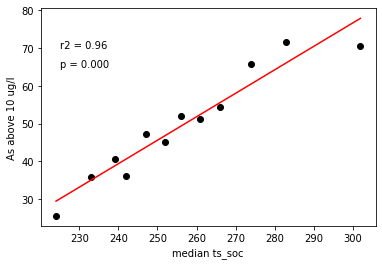

In [109]:
from scipy import stats
res = stats.linregress(statistics['median'], statistics['percent'])

plt.plot(statistics['median'], statistics['percent'], 'o', color='black')

plt.plot(statistics['median'], res.intercept + res.slope*statistics['median'], 'r', label='fitted line')
plt.annotate("r2 = {:.2f}".format(res.rvalue), (225, 70))
plt.annotate("p = {:.3f}".format(res.pvalue), (225, 65))

plt.xlabel('median ts_soc')
plt.ylabel('As above 10 ug/l')
plt.show()

**Data for RF model**

In [110]:
data_original = pd.read_csv('Grid_250m_As_JG_predictor2.csv') # cleaned predictors which has a significant relationships with the response variable
data_original.head()

,As_class,ts_soc,ts_silt,ts_ph,ts_clay,ts_cec,ss_soc,ss_silt,ss_ph,ss_clay,ss_cec,fluvisols,et0_yr,ai_et0,elevation,slope,precip,temp,distance_to_river,latitude,longitude
0,0,256,340,54,273,179,63,272,55,413,143,6,1500,11591,120,0.32849,1739,24.116667,640.149402,26.179411,93.999469
1,1,256,324,57,319,194,76,292,58,373,158,6,1489,12322,123,0.32849,1835,24.050000,2136.156457,26.315191,94.069099
2,1,269,328,56,315,185,68,281,57,391,150,6,1491,12116,132,0.32849,1807,23.975000,465.903551,26.272964,94.069210
3,1,276,334,57,318,199,65,305,58,377,162,6,1495,11820,115,0.32849,1768,24.116667,527.069827,26.231744,94.010314
4,1,265,321,57,277,165,56,268,59,411,138,7,1483,12764,114,0.32849,1893,24.058333,277.008355,26.382968,94.128657


In [111]:
data = data_original.drop(['latitude', 'longitude'], axis=1)
data

,As_class,ts_soc,ts_silt,ts_ph,ts_clay,ts_cec,ss_soc,ss_silt,ss_ph,ss_clay,ss_cec,fluvisols,et0_yr,ai_et0,elevation,slope,precip,temp,distance_to_river
0,0,256,340,54,273,179,63,272,55,413,143,6,1500,11591,120,0.328490,1739,24.116667,640.149402
1,1,256,324,57,319,194,76,292,58,373,158,6,1489,12322,123,0.328490,1835,24.050000,2136.156457
2,1,269,328,56,315,185,68,281,57,391,150,6,1491,12116,132,0.328490,1807,23.975000,465.903551
3,1,276,334,57,318,199,65,305,58,377,162,6,1495,11820,115,0.328490,1768,24.116667,527.069827
4,1,265,321,57,277,165,56,268,59,411,138,7,1483,12764,114,0.328490,1893,24.058333,277.008355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,0,242,334,54,264,175,88,300,55,351,149,8,1485,14052,91,8.805429,2088,24.100000,1319.758530
2388,0,220,315,53,278,180,76,297,54,345,157,19,1471,14677,92,8.805429,2160,23.983333,1041.338172
2389,0,241,338,55,265,163,62,325,56,336,146,13,1490,14469,89,9.125731,2156,24.133333,1438.933689
2390,0,243,376,55,243,155,73,357,56,316,137,8,1486,14178,94,10.200527,2107,24.083333,1853.253930


In [112]:
data_pred = data.drop(['As_class'], axis=1) # predictor of all data
data_pred.head()

,ts_soc,ts_silt,ts_ph,ts_clay,ts_cec,ss_soc,ss_silt,ss_ph,ss_clay,ss_cec,fluvisols,et0_yr,ai_et0,elevation,slope,precip,temp,distance_to_river
0,256,340,54,273,179,63,272,55,413,143,6,1500,11591,120,0.32849,1739,24.116667,640.149402
1,256,324,57,319,194,76,292,58,373,158,6,1489,12322,123,0.32849,1835,24.050000,2136.156457
2,269,328,56,315,185,68,281,57,391,150,6,1491,12116,132,0.32849,1807,23.975000,465.903551
3,276,334,57,318,199,65,305,58,377,162,6,1495,11820,115,0.32849,1768,24.116667,527.069827
4,265,321,57,277,165,56,268,59,411,138,7,1483,12764,114,0.32849,1893,24.058333,277.008355


In [113]:
data_res = data['As_class'] # response of all data
data_res.head()

0    0
1    1
2    1
3    1
4    1
Name: As_class, dtype: int64

In [114]:
data['As_class'].value_counts() # 50.46% of class 0 (As <10 ug/l)

0    1207
1    1185
Name: As_class, dtype: int64

In [115]:
# training and testing dataset split 80/20 with startified sampling.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['As_class'], axis='columns'),data.As_class,test_size=0.2, stratify = data.As_class) # train (80%) and test (20%) split with stratified sampling

In [116]:
y_test.value_counts() # 50.5

0    242
1    237
Name: As_class, dtype: int64

In [117]:
y_train.value_counts() # 50.44

0    965
1    948
Name: As_class, dtype: int64

**RF model**

In [118]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000,
                               oob_score=True,
                               max_features=5) # 5 predictor variables were used at a time to grow each tree
model.fit(X_train, y_train)

RandomForestClassifier(max_features=5, n_estimators=1000, oob_score=True)

In [119]:
model.score(X_test,y_test) # this is prediction accuracy

0.8392484342379958

In [120]:
model.oob_score_ # model accuracy

0.8332462101411395

In [121]:
from sklearn.model_selection import cross_val_score
rf_cv_score1 = cross_val_score(model, data_pred, data_res, cv=10, scoring='accuracy')

In [122]:
print(rf_cv_score1)
print("Mean accuracy - Random Forest: ", rf_cv_score1.mean())

[0.83333333 0.83333333 0.88284519 0.82426778 0.87029289 0.83682008
 0.86610879 0.86610879 0.78242678 0.80753138]
Mean accuracy - Random Forest:  0.8403068340306833


**Testing recursive feature elimination**
- not needed in this case because I use variables that have a significant relationships to response variables.
- you can do this without looking at statistical significance and select only the highly important variables.

In [123]:
from sklearn.feature_selection import RFE

In [124]:
estimator = RandomForestClassifier(n_estimators=500, oob_score=True)
selector = RFE(estimator, n_features_to_select=15, step=1)
selector = selector.fit(X_train, y_train)

print(selector.support_)
print(selector.ranking_) # all one's are the top 15 features, while 2, 3, and 4 can be eliminated from the model.

[ True  True False  True  True  True  True False  True False  True  True
  True  True  True  True  True  True]
[1 1 4 1 1 1 1 3 1 2 1 1 1 1 1 1 1 1]


In [125]:
selector.score(X_test,y_test) # we can see not much change in accuracy (mean accuracy was 0.837 after 10 fold cross validation)

0.8350730688935282

**Calculating pearson residual for model under-/over- prediction**

In [126]:
import dalex as dx
arsenic_rf_exp = dx.Explainer(model, data_pred, data_res)

Preparation of a new explainer is initiated

  -> data              : 2392 rows 18 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2392 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7fcf065a3b00> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


  -> predicted values  : min = 0.001, mean = 0.493, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.978, mean = 0.00241, max = 0.981
  -> model_info        : package sklearn

A new explainer has been created!


In [127]:
as_rf = arsenic_rf_exp.model_diagnostics()
as_rf.result

,ts_soc,ts_silt,ts_ph,ts_clay,ts_cec,ss_soc,ss_silt,ss_ph,ss_clay,ss_cec,fluvisols,et0_yr,ai_et0,elevation,slope,precip,temp,distance_to_river,y,y_hat,residuals,abs_residuals,label,ids
0,256,340,54,273,179,63,272,55,413,143,6,1500,11591,120,0.328490,1739,24.116667,640.149402,0,0.148,-0.148,0.148,RandomForestClassifier,1
1,256,324,57,319,194,76,292,58,373,158,6,1489,12322,123,0.328490,1835,24.050000,2136.156457,1,0.947,0.053,0.053,RandomForestClassifier,2
2,269,328,56,315,185,68,281,57,391,150,6,1491,12116,132,0.328490,1807,23.975000,465.903551,1,0.825,0.175,0.175,RandomForestClassifier,3
3,276,334,57,318,199,65,305,58,377,162,6,1495,11820,115,0.328490,1768,24.116667,527.069827,1,0.866,0.134,0.134,RandomForestClassifier,4
4,265,321,57,277,165,56,268,59,411,138,7,1483,12764,114,0.328490,1893,24.058333,277.008355,1,0.983,0.017,0.017,RandomForestClassifier,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,242,334,54,264,175,88,300,55,351,149,8,1485,14052,91,8.805429,2088,24.100000,1319.758530,0,0.060,-0.060,0.060,RandomForestClassifier,2388
2388,220,315,53,278,180,76,297,54,345,157,19,1471,14677,92,8.805429,2160,23.983333,1041.338172,0,0.682,-0.682,0.682,RandomForestClassifier,2389
2389,241,338,55,265,163,62,325,56,336,146,13,1490,14469,89,9.125731,2156,24.133333,1438.933689,0,0.080,-0.080,0.080,RandomForestClassifier,2390
2390,243,376,55,243,155,73,357,56,316,137,8,1486,14178,94,10.200527,2107,24.083333,1853.253930,0,0.080,-0.080,0.080,RandomForestClassifier,2391


In [128]:
as_rf = pd.DataFrame(as_rf.result)

In [129]:
from numpy import sqrt 
as_rf['pearson_residual'] = (as_rf['y']-as_rf['y_hat']) / sqrt(as_rf['y_hat']*(1-as_rf['y_hat'])) # manually calculating pearson residual
as_rf

,ts_soc,ts_silt,ts_ph,ts_clay,ts_cec,ss_soc,ss_silt,ss_ph,ss_clay,ss_cec,fluvisols,et0_yr,ai_et0,elevation,slope,precip,temp,distance_to_river,y,y_hat,residuals,abs_residuals,label,ids,pearson_residual
0,256,340,54,273,179,63,272,55,413,143,6,1500,11591,120,0.328490,1739,24.116667,640.149402,0,0.148,-0.148,0.148,RandomForestClassifier,1,-0.416784
1,256,324,57,319,194,76,292,58,373,158,6,1489,12322,123,0.328490,1835,24.050000,2136.156457,1,0.947,0.053,0.053,RandomForestClassifier,2,0.236572
2,269,328,56,315,185,68,281,57,391,150,6,1491,12116,132,0.328490,1807,23.975000,465.903551,1,0.825,0.175,0.175,RandomForestClassifier,3,0.460566
3,276,334,57,318,199,65,305,58,377,162,6,1495,11820,115,0.328490,1768,24.116667,527.069827,1,0.866,0.134,0.134,RandomForestClassifier,4,0.393363
4,265,321,57,277,165,56,268,59,411,138,7,1483,12764,114,0.328490,1893,24.058333,277.008355,1,0.983,0.017,0.017,RandomForestClassifier,5,0.131507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,242,334,54,264,175,88,300,55,351,149,8,1485,14052,91,8.805429,2088,24.100000,1319.758530,0,0.060,-0.060,0.060,RandomForestClassifier,2388,-0.252646
2388,220,315,53,278,180,76,297,54,345,157,19,1471,14677,92,8.805429,2160,23.983333,1041.338172,0,0.682,-0.682,0.682,RandomForestClassifier,2389,-1.464464
2389,241,338,55,265,163,62,325,56,336,146,13,1490,14469,89,9.125731,2156,24.133333,1438.933689,0,0.080,-0.080,0.080,RandomForestClassifier,2390,-0.294884
2390,243,376,55,243,155,73,357,56,316,137,8,1486,14178,94,10.200527,2107,24.083333,1853.253930,0,0.080,-0.080,0.080,RandomForestClassifier,2391,-0.294884


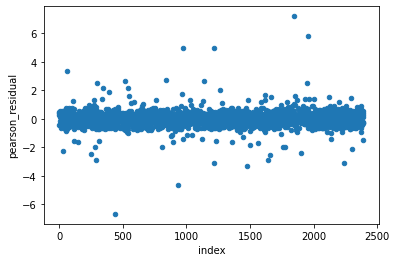

In [130]:
as_rf.reset_index().plot.scatter(x = 'index', y = 'pearson_residual') # pearson residuals to check model prediction (under: >=2 and over: <= -2)

In [131]:
as_rf['index_ID'] = data_original.index
as_rf

,ts_soc,ts_silt,ts_ph,ts_clay,ts_cec,ss_soc,ss_silt,ss_ph,ss_clay,ss_cec,fluvisols,et0_yr,ai_et0,elevation,slope,precip,temp,distance_to_river,y,y_hat,residuals,abs_residuals,label,ids,pearson_residual,index_ID
0,256,340,54,273,179,63,272,55,413,143,6,1500,11591,120,0.328490,1739,24.116667,640.149402,0,0.148,-0.148,0.148,RandomForestClassifier,1,-0.416784,0
1,256,324,57,319,194,76,292,58,373,158,6,1489,12322,123,0.328490,1835,24.050000,2136.156457,1,0.947,0.053,0.053,RandomForestClassifier,2,0.236572,1
2,269,328,56,315,185,68,281,57,391,150,6,1491,12116,132,0.328490,1807,23.975000,465.903551,1,0.825,0.175,0.175,RandomForestClassifier,3,0.460566,2
3,276,334,57,318,199,65,305,58,377,162,6,1495,11820,115,0.328490,1768,24.116667,527.069827,1,0.866,0.134,0.134,RandomForestClassifier,4,0.393363,3
4,265,321,57,277,165,56,268,59,411,138,7,1483,12764,114,0.328490,1893,24.058333,277.008355,1,0.983,0.017,0.017,RandomForestClassifier,5,0.131507,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,242,334,54,264,175,88,300,55,351,149,8,1485,14052,91,8.805429,2088,24.100000,1319.758530,0,0.060,-0.060,0.060,RandomForestClassifier,2388,-0.252646,2387
2388,220,315,53,278,180,76,297,54,345,157,19,1471,14677,92,8.805429,2160,23.983333,1041.338172,0,0.682,-0.682,0.682,RandomForestClassifier,2389,-1.464464,2388
2389,241,338,55,265,163,62,325,56,336,146,13,1490,14469,89,9.125731,2156,24.133333,1438.933689,0,0.080,-0.080,0.080,RandomForestClassifier,2390,-0.294884,2389
2390,243,376,55,243,155,73,357,56,316,137,8,1486,14178,94,10.200527,2107,24.083333,1853.253930,0,0.080,-0.080,0.080,RandomForestClassifier,2391,-0.294884,2390


In [132]:
data_original_c = data_original.loc[:, ['latitude','longitude']]
data_original_c

,latitude,longitude
0,26.179411,93.999469
1,26.315191,94.069099
2,26.272964,94.069210
3,26.231744,94.010314
4,26.382968,94.128657
...,...,...
2387,26.610469,93.734584
2388,26.656383,93.984746
2389,26.661029,93.789792
2390,26.617150,93.636350


In [133]:
data_original_c['index'] = data_original.index
data_original_c

,latitude,longitude,index
0,26.179411,93.999469,0
1,26.315191,94.069099,1
2,26.272964,94.069210,2
3,26.231744,94.010314,3
4,26.382968,94.128657,4
...,...,...,...
2387,26.610469,93.734584,2387
2388,26.656383,93.984746,2388
2389,26.661029,93.789792,2389
2390,26.617150,93.636350,2390


In [134]:
as_rf = as_rf.merge(data_original_c, left_on='index_ID', right_on='index')
as_rf

,ts_soc,ts_silt,ts_ph,ts_clay,ts_cec,ss_soc,ss_silt,ss_ph,ss_clay,ss_cec,fluvisols,et0_yr,ai_et0,elevation,slope,precip,temp,distance_to_river,y,y_hat,residuals,abs_residuals,label,ids,pearson_residual,index_ID,latitude,longitude,index
0,256,340,54,273,179,63,272,55,413,143,6,1500,11591,120,0.328490,1739,24.116667,640.149402,0,0.148,-0.148,0.148,RandomForestClassifier,1,-0.416784,0,26.179411,93.999469,0
1,256,324,57,319,194,76,292,58,373,158,6,1489,12322,123,0.328490,1835,24.050000,2136.156457,1,0.947,0.053,0.053,RandomForestClassifier,2,0.236572,1,26.315191,94.069099,1
2,269,328,56,315,185,68,281,57,391,150,6,1491,12116,132,0.328490,1807,23.975000,465.903551,1,0.825,0.175,0.175,RandomForestClassifier,3,0.460566,2,26.272964,94.069210,2
3,276,334,57,318,199,65,305,58,377,162,6,1495,11820,115,0.328490,1768,24.116667,527.069827,1,0.866,0.134,0.134,RandomForestClassifier,4,0.393363,3,26.231744,94.010314,3
4,265,321,57,277,165,56,268,59,411,138,7,1483,12764,114,0.328490,1893,24.058333,277.008355,1,0.983,0.017,0.017,RandomForestClassifier,5,0.131507,4,26.382968,94.128657,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,242,334,54,264,175,88,300,55,351,149,8,1485,14052,91,8.805429,2088,24.100000,1319.758530,0,0.060,-0.060,0.060,RandomForestClassifier,2388,-0.252646,2387,26.610469,93.734584,2387
2388,220,315,53,278,180,76,297,54,345,157,19,1471,14677,92,8.805429,2160,23.983333,1041.338172,0,0.682,-0.682,0.682,RandomForestClassifier,2389,-1.464464,2388,26.656383,93.984746,2388
2389,241,338,55,265,163,62,325,56,336,146,13,1490,14469,89,9.125731,2156,24.133333,1438.933689,0,0.080,-0.080,0.080,RandomForestClassifier,2390,-0.294884,2389,26.661029,93.789792,2389
2390,243,376,55,243,155,73,357,56,316,137,8,1486,14178,94,10.200527,2107,24.083333,1853.253930,0,0.080,-0.080,0.080,RandomForestClassifier,2391,-0.294884,2390,26.617150,93.636350,2390


In [135]:
as_rf.to_csv('as_rf_pearson_residuals.csv') # for visualization

**Predicted probability for yes or no based on RF model**

In [136]:
y_pred = model.predict(X_test) # class
y_pred_prob = model.predict_proba(X_test) # probability
y_pred = pd.DataFrame(y_pred) # class to a dataframe

data_pred_prob = model.predict_proba(data_pred) # probability

In [137]:
data_pred_prob = pd.DataFrame(data_pred_prob) # probability to a dataframe
data_pred_prob

,0,1
0,0.852,0.148
1,0.053,0.947
2,0.175,0.825
3,0.134,0.866
4,0.017,0.983
...,...,...
2387,0.940,0.060
2388,0.318,0.682
2389,0.920,0.080
2390,0.920,0.080


In [138]:
y_pred

,0
0,1
1,1
2,1
3,0
4,0
...,...
474,1
475,1
476,0
477,1


In [139]:
y_pred = pd.DataFrame(y_pred) # class to a dataframe
y_pred_prob = pd.DataFrame(y_pred_prob) # probability to a dataframe
y_pred_pc = pd.concat([y_pred_prob, y_pred], axis=1, ignore_index=True) # combining probability and class into one dataframe
y_pred_pc.head()

,0,1,2
0,0.037,0.963,1
1,0.128,0.872,1
2,0.195,0.805,1
3,0.833,0.167,0
4,0.588,0.412,0


In [140]:
y_test.reset_index(drop=True, inplace=True)
y_pred_xpc = pd.concat([y_pred_pc, y_test], axis=1, ignore_index=True) # combining probability and class into one dataframe plus original class
y_pred_xpc

,0,1,2,3
0,0.037,0.963,1,1
1,0.128,0.872,1,1
2,0.195,0.805,1,1
3,0.833,0.167,0,0
4,0.588,0.412,0,0
...,...,...,...,...
474,0.116,0.884,1,1
475,0.029,0.971,1,1
476,0.938,0.062,0,0
477,0.122,0.878,1,1


In [141]:
y_pred_xpc = y_pred_xpc.rename(columns={0:"prob_0"})
y_pred_xpc = y_pred_xpc.rename(columns={1:"prob_1"})
y_pred_xpc = y_pred_xpc.rename(columns={2:"pred_class"})
y_pred_xpc = y_pred_xpc.rename(columns={3:"actual_class"})
y_pred_xpc

,prob_0,prob_1,pred_class,actual_class
0,0.037,0.963,1,1
1,0.128,0.872,1,1
2,0.195,0.805,1,1
3,0.833,0.167,0,0
4,0.588,0.412,0,0
...,...,...,...,...
474,0.116,0.884,1,1
475,0.029,0.971,1,1
476,0.938,0.062,0,0
477,0.122,0.878,1,1


**ROC curve - sensitivity and specificity**

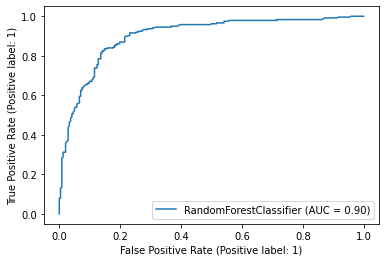

In [142]:
from sklearn.metrics import RocCurveDisplay # showing ROC curve
rf_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

In [143]:
from sklearn.metrics import roc_curve # calculating fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[1])

In [144]:
df = pd.DataFrame(data=[fpr, tpr, thresholds]).T
df

,0,1,2
0,0.000000,0.000000,1.995
1,0.000000,0.004219,0.995
2,0.000000,0.012658,0.993
3,0.000000,0.021097,0.992
4,0.000000,0.046414,0.984
...,...,...,...
193,0.954545,0.995781,0.021
194,0.958678,1.000000,0.019
195,0.962810,1.000000,0.017
196,0.979339,1.000000,0.014


In [145]:
df = df.rename(columns={0:"fpr"})
df = df.rename(columns={1:"tpr_sensitivity"})
df = df.rename(columns={2:"thresholds"})
df

,fpr,tpr_sensitivity,thresholds
0,0.000000,0.000000,1.995
1,0.000000,0.004219,0.995
2,0.000000,0.012658,0.993
3,0.000000,0.021097,0.992
4,0.000000,0.046414,0.984
...,...,...,...
193,0.954545,0.995781,0.021
194,0.958678,1.000000,0.019
195,0.962810,1.000000,0.017
196,0.979339,1.000000,0.014


In [146]:
df['specificity'] = 1 - df["fpr"]
df

,fpr,tpr_sensitivity,thresholds,specificity
0,0.000000,0.000000,1.995,1.000000
1,0.000000,0.004219,0.995,1.000000
2,0.000000,0.012658,0.993,1.000000
3,0.000000,0.021097,0.992,1.000000
4,0.000000,0.046414,0.984,1.000000
...,...,...,...,...
193,0.954545,0.995781,0.021,0.045455
194,0.958678,1.000000,0.019,0.041322
195,0.962810,1.000000,0.017,0.037190
196,0.979339,1.000000,0.014,0.020661


In [147]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[1])

accuracy_scores = []
for thresh in thresholds:
    accuracy_scores.append(accuracy_score(y_test, [m > thresh for m in y_pred_prob[1]]))

accuracies = np.array(accuracy_scores)
max_accuracy = accuracies.max() 
max_accuracy_threshold =  thresholds[accuracies.argmax()]

In [148]:
df1 = pd.DataFrame(data=[accuracies]).T
df1 = df1.rename(columns={0:"accuracy"})
df1

,accuracy
0,0.505219
1,0.505219
2,0.509395
3,0.511482
4,0.526096
...,...
193,0.524008
194,0.515658
195,0.515658
196,0.509395


In [149]:
df2 = pd.concat([df, df1], axis=1)
df2

,fpr,tpr_sensitivity,thresholds,specificity,accuracy
0,0.000000,0.000000,1.995,1.000000,0.505219
1,0.000000,0.004219,0.995,1.000000,0.505219
2,0.000000,0.012658,0.993,1.000000,0.509395
3,0.000000,0.021097,0.992,1.000000,0.511482
4,0.000000,0.046414,0.984,1.000000,0.526096
...,...,...,...,...,...
193,0.954545,0.995781,0.021,0.045455,0.524008
194,0.958678,1.000000,0.019,0.041322,0.515658
195,0.962810,1.000000,0.017,0.037190,0.515658
196,0.979339,1.000000,0.014,0.020661,0.509395


In [150]:
df2.to_csv('df2_cutoff.csv') # for visualization

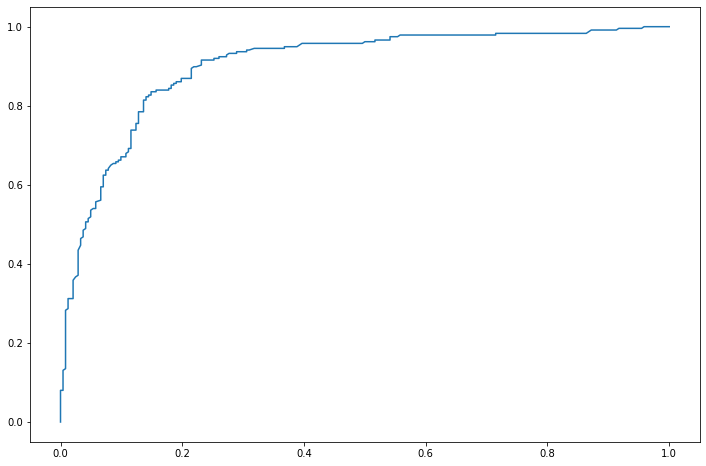

In [151]:
plt.figure(figsize=(12, 8))
plt.plot(df2['fpr'], df2['tpr_sensitivity'])

In [152]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(data_res, data_pred_prob[1])

df_p = pd.DataFrame(data=[precision, recall, thresholds]).T
df_p = df_p.rename(columns={0:"precision"})
df_p = df_p.rename(columns={1:"recall"})
df_p = df_p.rename(columns={2:"thresholds"})
df_p

accuracy_scores = []
for thresh in thresholds:
    accuracy_scores.append(accuracy_score(data_res, [m > thresh for m in data_pred_prob[1]]))

accuracies = np.array(accuracy_scores)
max_accuracy = accuracies.max() 
max_accuracy_threshold =  thresholds[accuracies.argmax()]

In [153]:
df3 = pd.DataFrame(data=[accuracies]).T
df3 = df3.rename(columns={0:"accuracy"})
df3

,accuracy
0,0.566472
1,0.571906
2,0.576087
3,0.581104
4,0.589883
...,...
633,0.512960
634,0.512124
635,0.507107
636,0.505017


In [154]:
df4 = pd.concat([df_p, df3], axis=1)
df4

,precision,recall,thresholds,accuracy
0,0.530201,1.000000,0.019,0.566472
1,0.533333,0.999156,0.020,0.571906
2,0.536475,0.999156,0.021,0.576087
3,0.538917,0.999156,0.022,0.581104
4,0.541876,0.999156,0.023,0.589883
...,...,...,...,...
634,1.000000,0.016878,0.997,0.512124
635,1.000000,0.015190,0.998,0.507107
636,1.000000,0.005063,0.999,0.505017
637,1.000000,0.000844,1.000,0.504599


In [155]:
df4.to_csv('df3_cutoff.csv')

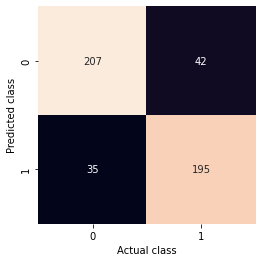

In [156]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Actual class')
plt.ylabel('Predicted class');

In [157]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (fn + tp)
positive_pred_value = tp / (tp + fp)
negative_pred_value = tn / (tn + fn)
prevalence = (tn + fp) / (tn + fp + fn + tp)

print(specificity)
print(sensitivity)
print(positive_pred_value)
print(negative_pred_value)
print(prevalence)

0.8553719008264463
0.8227848101265823
0.8478260869565217
0.8313253012048193
0.5052192066805845


In [158]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, cohen_kappa_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(cohen_kappa_score(y_test, y_pred))

[[207  35]
 [ 42 195]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       242
           1       0.85      0.82      0.84       237

    accuracy                           0.84       479
   macro avg       0.84      0.84      0.84       479
weighted avg       0.84      0.84      0.84       479

0.8392484342379958
0.8390783554765143
0.8478260869565217
0.6783636950284723


**Cross-validation ROC scores**

In [159]:
from sklearn.model_selection import cross_val_score
rf_cv_score = cross_val_score(model, data_pred, data_res, cv=10, scoring='roc_auc')

In [160]:
print(rf_cv_score)
print("Mean AUC Score - Random Forest: ", rf_cv_score.mean())

[0.90086117 0.87936662 0.93003222 0.89378765 0.92446421 0.89865527
 0.92117243 0.93487395 0.87440476 0.88109244]
Mean AUC Score - Random Forest:  0.9038710722417556


In [161]:
rf_cv_score1 = cross_val_score(model, data_pred, data_res, cv=10, scoring='accuracy')

In [162]:
print(rf_cv_score1)
print("Mean accuracy - Random Forest: ", rf_cv_score1.mean())

[0.83333333 0.82916667 0.87029289 0.82845188 0.87029289 0.83682008
 0.86192469 0.85774059 0.78661088 0.79916318]
Mean accuracy - Random Forest:  0.8373797071129708


In [163]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, y_pred)

0.6783636950284723

**Predicting probability and classes for unknown sample locations**

In [164]:
pred_data = pd.read_csv('Grid_250_As_G_pts.csv') # Golaghat
pred_data1 = pd.read_csv('Grid_250_As_J_pts.csv') # Jorhat

In [165]:
pred_data

,ts_soc,ts_silt,ts_ph,ts_clay,ts_cec,ss_soc,ss_silt,ss_ph,ss_clay,ss_cec,fluvisols,et0_yr,ai_et0,slope,elevation,precip,temp,distance_to_river,latitude,longitude
0,0,0,0,0,0,0,0,0,0,0,17.0,1495,15722,5.595448,52.0,2352,24.183333,349.214900,26.802073,93.706701
1,292,358,57,286,162,85,351,59,331,155,14.0,1486,15677,21.877216,58.0,2330,24.000000,1396.030698,26.725236,93.373386
2,319,390,57,251,177,167,369,59,313,168,14.0,1481,15376,1.038675,61.0,2278,23.983333,1407.064909,26.690321,93.315030
3,0,0,0,0,0,0,0,0,0,0,NaN,1481,15705,7.137265,61.0,2326,24.041667,1170.832837,26.720795,93.348109
4,0,0,0,0,0,0,0,0,0,0,NaN,1481,15650,10.205595,61.0,2318,24.016667,55.443368,26.717535,93.384934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56038,538,351,51,297,237,122,336,53,363,200,2.0,1479,14528,18.889793,360.0,2150,23.083333,4132.470897,26.594892,93.512598
56039,260,355,55,277,178,76,302,56,393,139,9.0,1511,10902,0.985384,NaN,1648,24.108333,1647.195026,26.000876,93.885960
56040,262,359,54,282,181,48,307,56,392,143,11.0,1511,10902,0.985384,NaN,1648,24.108333,1398.446964,26.000655,93.888395
56041,285,370,55,272,181,43,300,57,405,146,12.0,1511,10902,0.734494,NaN,1648,24.108333,1149.698901,26.000434,93.890830


In [166]:
pred_data1

,ts_soc,ts_silt,ts_ph,ts_clay,ts_cec,ss_soc,ss_silt,ss_ph,ss_clay,ss_cec,fluvisols,et0_yr,ai_et0,slope,precip,temp,distance_to_river,elevation,latitude,longitude
0,377,287,57,302,166,134,296,58,309,137,13.0,1439,18337,22.059917,2639,23.733334,1954.423724,62,26.985278,94.382606
1,358,330,58,277,152,115,334,59,318,127,14.0,1467,16397,8.072643,2407,23.900000,1406.463874,65,26.832120,93.863815
2,393,290,58,283,154,354,291,59,315,132,11.0,1434,18013,6.216869,2584,23.633333,271.925130,66,26.961900,94.394662
3,373,326,57,269,168,164,330,58,323,135,18.0,1449,17394,2.076667,2521,23.816667,2009.468937,67,26.871816,94.081576
4,0,0,0,0,0,0,0,0,0,0,NaN,1426,18222,9.478460,2600,23.666667,443.542184,67,26.967775,94.402807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50021,407,313,51,318,225,106,292,52,370,188,3.0,1429,14386,23.269426,2057,22.766667,6080.621488,367,26.541259,94.287732
50022,390,335,51,316,220,101,318,52,364,181,4.0,1428,14463,30.208181,2066,22.766667,5797.800661,369,26.545188,94.293132
50023,407,333,51,314,224,90,313,52,368,188,4.0,1428,14463,19.841146,2066,22.766667,5906.205712,371,26.544956,94.295575
50024,367,297,53,323,218,96,278,53,368,192,5.0,1426,14427,12.798765,2058,22.816667,5810.776768,376,26.536402,94.292101


In [167]:
pred_data_test = pd.concat([pred_data, pred_data1], axis=0) # original unknown sets of data merged with predicted class and probs
pred_data_test

,ts_soc,ts_silt,ts_ph,ts_clay,ts_cec,ss_soc,ss_silt,ss_ph,ss_clay,ss_cec,fluvisols,et0_yr,ai_et0,slope,elevation,precip,temp,distance_to_river,latitude,longitude
0,0,0,0,0,0,0,0,0,0,0,17.0,1495,15722,5.595448,52.0,2352,24.183333,349.214900,26.802073,93.706701
1,292,358,57,286,162,85,351,59,331,155,14.0,1486,15677,21.877216,58.0,2330,24.000000,1396.030698,26.725236,93.373386
2,319,390,57,251,177,167,369,59,313,168,14.0,1481,15376,1.038675,61.0,2278,23.983333,1407.064909,26.690321,93.315030
3,0,0,0,0,0,0,0,0,0,0,NaN,1481,15705,7.137265,61.0,2326,24.041667,1170.832837,26.720795,93.348109
4,0,0,0,0,0,0,0,0,0,0,NaN,1481,15650,10.205595,61.0,2318,24.016667,55.443368,26.717535,93.384934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50021,407,313,51,318,225,106,292,52,370,188,3.0,1429,14386,23.269426,367.0,2057,22.766667,6080.621488,26.541259,94.287732
50022,390,335,51,316,220,101,318,52,364,181,4.0,1428,14463,30.208181,369.0,2066,22.766667,5797.800661,26.545188,94.293132
50023,407,333,51,314,224,90,313,52,368,188,4.0,1428,14463,19.841146,371.0,2066,22.766667,5906.205712,26.544956,94.295575
50024,367,297,53,323,218,96,278,53,368,192,5.0,1426,14427,12.798765,376.0,2058,22.816667,5810.776768,26.536402,94.292101


In [168]:
pred_data_test.dropna(inplace= True)
test = pred_data_test.iloc[:, 0:18]
pred_data_test

,ts_soc,ts_silt,ts_ph,ts_clay,ts_cec,ss_soc,ss_silt,ss_ph,ss_clay,ss_cec,fluvisols,et0_yr,ai_et0,slope,elevation,precip,temp,distance_to_river,latitude,longitude
0,0,0,0,0,0,0,0,0,0,0,17.0,1495,15722,5.595448,52.0,2352,24.183333,349.214900,26.802073,93.706701
1,292,358,57,286,162,85,351,59,331,155,14.0,1486,15677,21.877216,58.0,2330,24.000000,1396.030698,26.725236,93.373386
2,319,390,57,251,177,167,369,59,313,168,14.0,1481,15376,1.038675,61.0,2278,23.983333,1407.064909,26.690321,93.315030
5,0,0,0,0,0,0,0,0,0,0,11.0,1481,15683,5.086193,61.0,2323,24.008333,1472.541747,26.723467,93.368234
8,0,0,0,0,0,0,0,0,0,0,12.0,1470,15531,1.038675,62.0,2284,24.091667,2535.566012,26.757815,93.704169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50021,407,313,51,318,225,106,292,52,370,188,3.0,1429,14386,23.269426,367.0,2057,22.766667,6080.621488,26.541259,94.287732
50022,390,335,51,316,220,101,318,52,364,181,4.0,1428,14463,30.208181,369.0,2066,22.766667,5797.800661,26.545188,94.293132
50023,407,333,51,314,224,90,313,52,368,188,4.0,1428,14463,19.841146,371.0,2066,22.766667,5906.205712,26.544956,94.295575
50024,367,297,53,323,218,96,278,53,368,192,5.0,1426,14427,12.798765,376.0,2058,22.816667,5810.776768,26.536402,94.292101


In [169]:
pred_data_class = model.predict(test)
pred_data_prob = model.predict_proba(test)
p_class = pd.DataFrame(pred_data_class)
p_prob = pd.DataFrame(pred_data_prob)
p_class = p_class.rename(columns={0:"class"})
p_prob = p_prob.rename(columns={0:"prob_0"})
p_prob = p_prob.rename(columns={1:"prob_1"})
pred_df = pd.concat([p_class, p_prob], axis=1)
pred_data_test.reset_index(drop=True, inplace=True)
pred_df_loc = pd.concat([pred_data_test, pred_df], axis=1) # original unknown sets of data merged with predicted class and probs
pred_df_loc

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


,ts_soc,ts_silt,ts_ph,ts_clay,ts_cec,ss_soc,ss_silt,ss_ph,ss_clay,ss_cec,fluvisols,et0_yr,ai_et0,slope,elevation,precip,temp,distance_to_river,latitude,longitude,class,prob_0,prob_1
0,0,0,0,0,0,0,0,0,0,0,17.0,1495,15722,5.595448,52.0,2352,24.183333,349.214900,26.802073,93.706701,0,0.517,0.483
1,292,358,57,286,162,85,351,59,331,155,14.0,1486,15677,21.877216,58.0,2330,24.000000,1396.030698,26.725236,93.373386,0,0.595,0.405
2,319,390,57,251,177,167,369,59,313,168,14.0,1481,15376,1.038675,61.0,2278,23.983333,1407.064909,26.690321,93.315030,0,0.530,0.470
3,0,0,0,0,0,0,0,0,0,0,11.0,1481,15683,5.086193,61.0,2323,24.008333,1472.541747,26.723467,93.368234,0,0.528,0.472
4,0,0,0,0,0,0,0,0,0,0,12.0,1470,15531,1.038675,62.0,2284,24.091667,2535.566012,26.757815,93.704169,0,0.559,0.441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101160,407,313,51,318,225,106,292,52,370,188,3.0,1429,14386,23.269426,367.0,2057,22.766667,6080.621488,26.541259,94.287732,1,0.381,0.619
101161,390,335,51,316,220,101,318,52,364,181,4.0,1428,14463,30.208181,369.0,2066,22.766667,5797.800661,26.545188,94.293132,1,0.414,0.586
101162,407,333,51,314,224,90,313,52,368,188,4.0,1428,14463,19.841146,371.0,2066,22.766667,5906.205712,26.544956,94.295575,1,0.423,0.577
101163,367,297,53,323,218,96,278,53,368,192,5.0,1426,14427,12.798765,376.0,2058,22.816667,5810.776768,26.536402,94.292101,1,0.453,0.547


In [170]:
pred_df_loc['ts_soc'].isnull().sum()

0

In [171]:
pred_df_loc.to_csv('pred_df_loc.csv') # predicted probability for all locations

**Standard deviation of the classification for model uncertainty**

In [172]:
per_tree_pred = [model.predict(test) for model in model.estimators_] # standard deviation of the classification for model uncertainty
df = pd.DataFrame(per_tree_pred)
df_T = df.T
#df_T['mean'] = df_T.mean(axis=1)
df_T['sd'] = df_T.std(axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

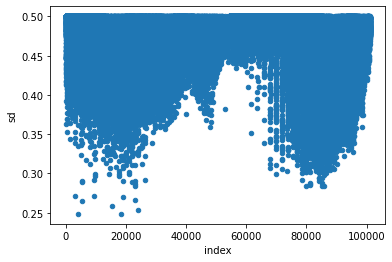

In [173]:
df_T.reset_index().plot.scatter(x = 'index', y = 'sd') # values close to zero indicate stronger agreement/consensus

In [174]:
df_T.reset_index(drop=True, inplace=True)
df_T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,sd
0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.499961
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.491138
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.499349
3,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.499465
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.496755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101160,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.485876
101161,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.492795
101162,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.494283
101163,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.498035


In [175]:
test2_c = pred_data_test[['latitude', 'longitude']]
test2_c.reset_index(drop=True, inplace=True)
test2_c

,latitude,longitude
0,26.802073,93.706701
1,26.725236,93.373386
2,26.690321,93.315030
3,26.723467,93.368234
4,26.757815,93.704169
...,...,...
101160,26.541259,94.287732
101161,26.545188,94.293132
101162,26.544956,94.295575
101163,26.536402,94.292101


In [176]:
df_T1 = pd.concat([df_T, test2_c], axis=1) # original unknown sets of data merged with predicted class and probs
df_T1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,sd,latitude,longitude
0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.499961,26.802073,93.706701
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.491138,26.725236,93.373386
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.499349,26.690321,93.315030
3,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.499465,26.723467,93.368234
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.496755,26.757815,93.704169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101160,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.485876,26.541259,94.287732
101161,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.492795,26.545188,94.293132
101162,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.494283,26.544956,94.295575
101163,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.498035,26.536402,94.292101


In [177]:
df_T1.to_csv('df_T_standard_deviation.csv')

**Data visualization of arsenic probability greater than 10 ug/l (WHO limit)**

In [178]:
!pip install geoplot

In [179]:
import geoplot as gplt

In [180]:
pred_df_loc_gdf = gpd.GeoDataFrame(
    pred_df_loc, geometry=gpd.points_from_xy(pred_df_loc.longitude, pred_df_loc.latitude))

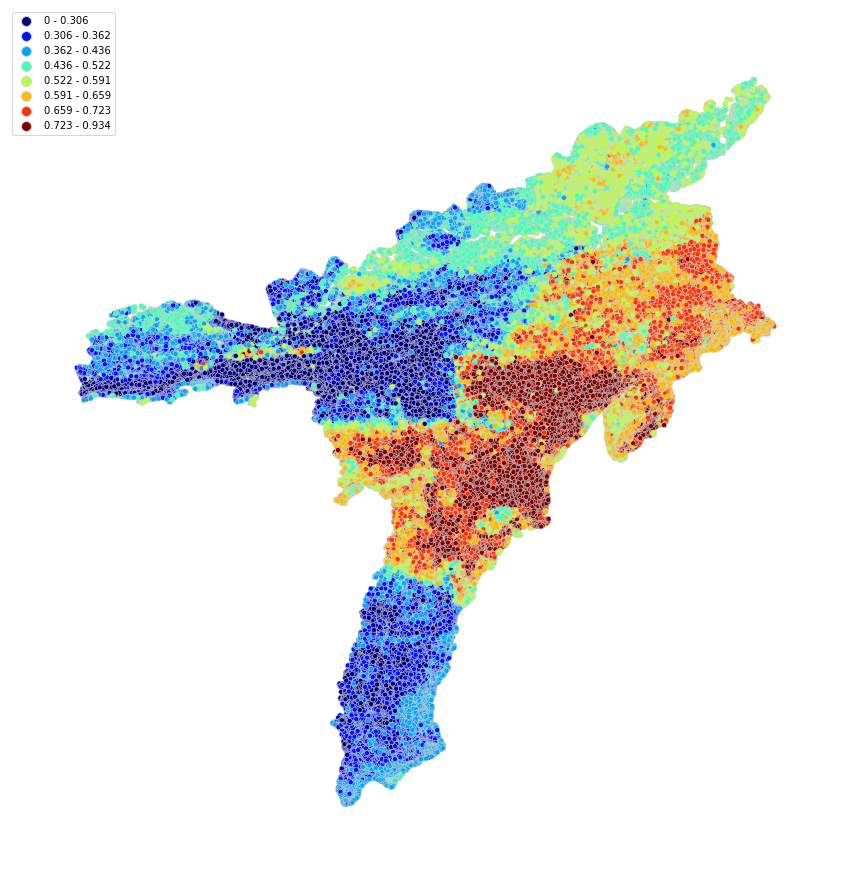

In [181]:
import mapclassify as mc
scheme = mc.Quantiles(pred_df_loc_gdf['prob_1'], k=8)
gplt.pointplot(
    pred_df_loc_gdf,
    hue='prob_1', legend=True, 
    edgecolor='lightgray', linewidth=0.5, figsize=(16,16), scheme=scheme, cmap='jet'
)

In [182]:
# THE END